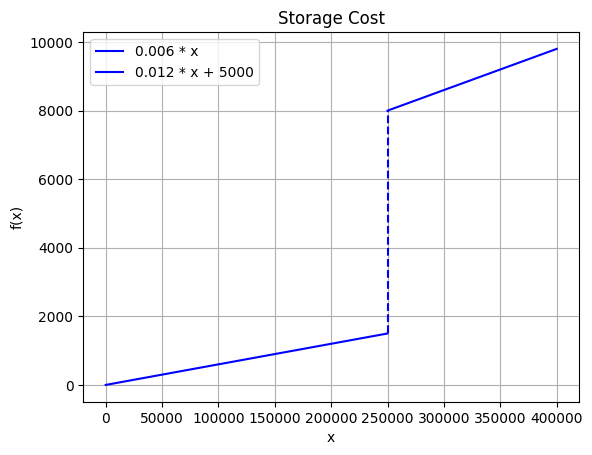

In [15]:
import numpy as np
import matplotlib.pyplot as plt

def storage_cost(x):
    if x < 0:
        return 0
    elif x < 250e3:
        return 0.006 * x
    else:
        return 0.012 * x + 5000

x1 = np.linspace(0, 250e3-1, 400)
x2 = np.linspace(250e3, 400e3, 400)
y1 = [storage_cost(xi) for xi in x1]
y2 = [storage_cost(xi) for xi in x2]

plt.plot(x1, y1, label="0.006 * x", color="blue")
plt.plot(x2, y2, label="0.012 * x + 5000", color="blue")
plt.plot([250e3, 250e3], [storage_cost(250e3-1), storage_cost(250e3)],linestyle='dashed', color='blue')
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Storage Cost")
plt.legend()
plt.grid()
plt.savefig("../docs/images/storage_cost.png", format="png")


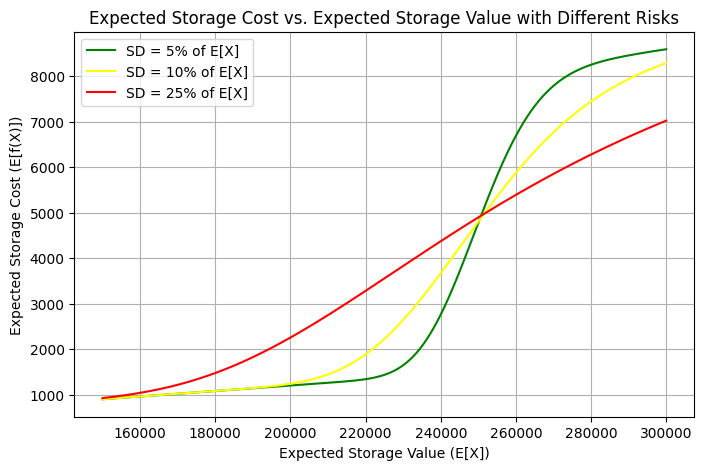

In [16]:
from scipy.stats import norm

# Define expected storage values and their standard deviations (5%, 10%, 25% of expected_storage)
expected_values = np.linspace(150e3, 300e3, 1_000)  # Range of expected storage values
sd_percentages = [0.05, 0.10, 0.25]  # Standard deviation as percentage of expected_storage
threshold = 250000  # Threshold value for storage cost
# Prepare storage cost results
storage_costs = {sd_pct: [] for sd_pct in sd_percentages}

# Compute expected storage costs for each expected value and standard deviation
for e in expected_values:
    for sd_pct in sd_percentages:
        sd = e * sd_pct  # Compute standard deviation
        z = (threshold - e) / sd  # Compute z-score
        Phi_z = norm.cdf(z)  # Probability of being below threshold
        one_minus_Phi_z = 1 - Phi_z  # Probability of being above threshold
        phi_z = norm.pdf(z)  # PDF at z

        # Compute expected values given truncation
        E_X_below = e - sd * (phi_z / Phi_z) if Phi_z > 0 else e  # Avoid division by zero
        E_X_above = e + sd * (phi_z / one_minus_Phi_z) if one_minus_Phi_z > 0 else e

        # Compute expected storage cost
        E_f_X = (0.006 * E_X_below * Phi_z) + ((5000 + 0.012 * E_X_above) * one_minus_Phi_z)

        # Store result
        storage_costs[sd_pct].append(E_f_X)

colors = {0.05: "green", 0.10: "yellow", 0.25: "red"}

# Plot results
plt.figure(figsize=(8, 5))
for sd_pct in sd_percentages:
    plt.plot(expected_values, storage_costs[sd_pct],color=colors[sd_pct], label=f"SD = {int(sd_pct * 100)}% of E[X]")

plt.xlabel("Expected Storage Value (E[X])")
plt.ylabel("Expected Storage Cost (E[f(X)])")
plt.title("Expected Storage Cost vs. Expected Storage Value with Different Risks")
plt.legend()
plt.grid()
plt.show()

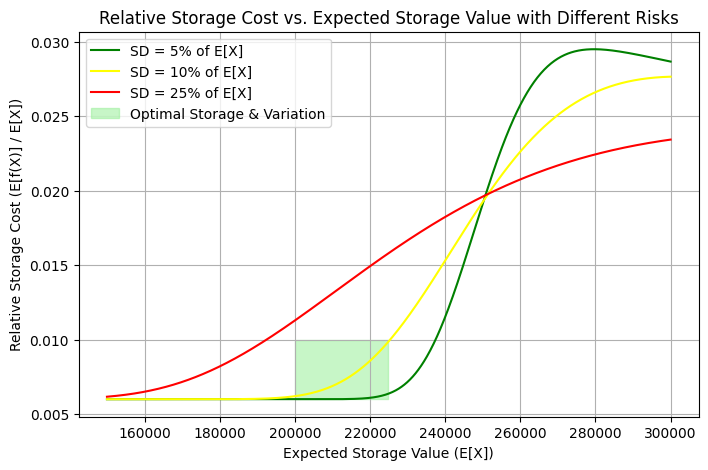

In [17]:
# Compute relative storage cost s(x) / x for each expected value and standard deviation
relative_storage_costs = {sd_pct: np.array(storage_costs[sd_pct]) / expected_values for sd_pct in sd_percentages}
goal_min, goal_max = 200000, 225000
goal_range = (expected_values >= goal_min) & (expected_values <= goal_max)

# Plot relative storage costs
plt.figure(figsize=(8, 5))
for sd_pct in sd_percentages:
    plt.plot(expected_values, relative_storage_costs[sd_pct], label=f"SD = {int(sd_pct * 100)}% of E[X]", color=colors[sd_pct])
plt.fill_between(expected_values[goal_range], 0.01, 0.006, color="lightgreen", alpha=0.5, label="Optimal Storage & Variation")

plt.xlabel("Expected Storage Value (E[X])")
plt.ylabel("Relative Storage Cost (E[f(X)] / E[X])")
plt.title("Relative Storage Cost vs. Expected Storage Value with Different Risks")
plt.legend()
plt.grid()
plt.savefig("../docs/images/relative_storage_cost_optimal.png", format="png")
plt.show()


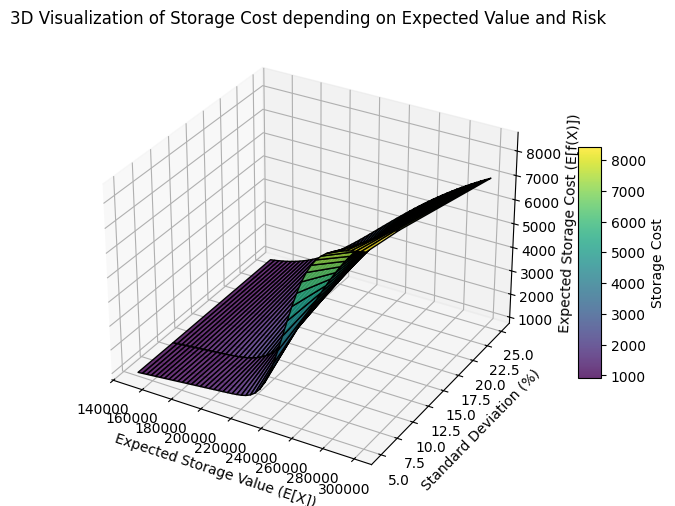

In [18]:
from mpl_toolkits.mplot3d import Axes3D

# Define meshgrid for expected storage values and standard deviations
expected_values_mesh, sd_percent_mesh = np.meshgrid(
        np.linspace(150e3, 300e3, 50),  # Expected storage values
        np.array([0.05, 0.10, 0.25])  # Standard deviations (as percentages of E[X])
)

# Compute expected storage costs for the meshgrid
storage_costs_mesh = np.zeros_like(expected_values_mesh)

for i in range(expected_values_mesh.shape[0]):
    for j in range(expected_values_mesh.shape[1]):
        e = expected_values_mesh[i, j]
        sd = e * sd_percent_mesh[i, j]  # Compute standard deviation
        z = (threshold - e) / sd  # Compute z-score
        Phi_z = norm.cdf(z)  # Probability of being below threshold
        one_minus_Phi_z = 1 - Phi_z  # Probability of being above threshold
        phi_z = norm.pdf(z)  # PDF at z

        # Compute expected values given truncation
        E_X_below = e - sd * (phi_z / Phi_z) if Phi_z > 0 else e  # Avoid division by zero
        E_X_above = e + sd * (phi_z / one_minus_Phi_z) if one_minus_Phi_z > 0 else e

        # Compute expected storage cost
        storage_costs_mesh[i, j] = (0.006 * E_X_below * Phi_z) + ((5000 + 0.012 * E_X_above) * one_minus_Phi_z)

# Create 3D plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot surface
surf = ax.plot_surface(expected_values_mesh, sd_percent_mesh * 100, storage_costs_mesh, cmap="viridis", edgecolor='k', alpha=0.8)

# Labels
ax.set_xlabel("Expected Storage Value (E[X])")
ax.set_ylabel("Standard Deviation (%)")
ax.set_zlabel("Expected Storage Cost (E[f(X)])")
ax.set_title("3D Visualization of Storage Cost depending on Expected Value and Risk")

# Color bar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label="Storage Cost")

plt.show()


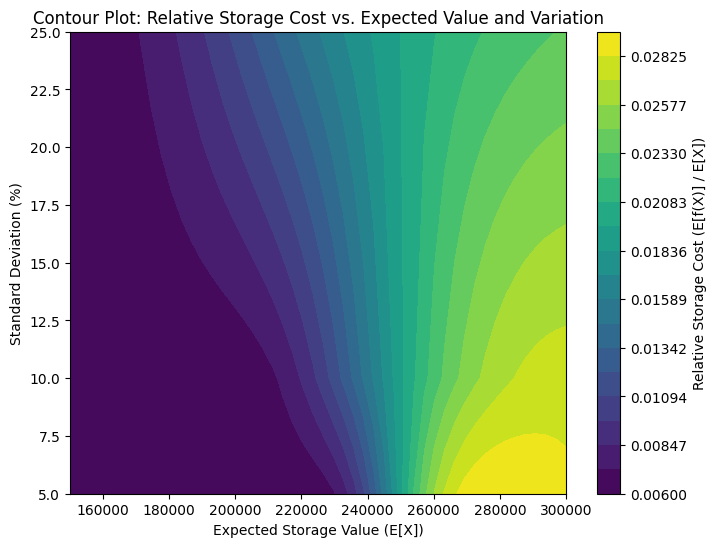

In [19]:
# Compute relative storage cost (E[f(X)] / E[X]) for contour plot
relative_storage_costs_mesh = storage_costs_mesh / expected_values_mesh

# Create contour plot for relative storage costs
fig, ax = plt.subplots(figsize=(8, 6))

# Generate contour levels for better visualization
contour_levels = np.linspace(np.min(relative_storage_costs_mesh), np.max(relative_storage_costs_mesh), 20)

# Contour plot
contour = ax.contourf(expected_values_mesh, sd_percent_mesh * 100, relative_storage_costs_mesh, levels=contour_levels, cmap="viridis")

# Add color bar
cbar = fig.colorbar(contour, ax=ax, label="Relative Storage Cost (E[f(X)] / E[X])")

# Labels and Title
ax.set_xlabel("Expected Storage Value (E[X])")
ax.set_ylabel("Standard Deviation (%)")
ax.set_title("Contour Plot: Relative Storage Cost vs. Expected Value and Variation")

plt.show()

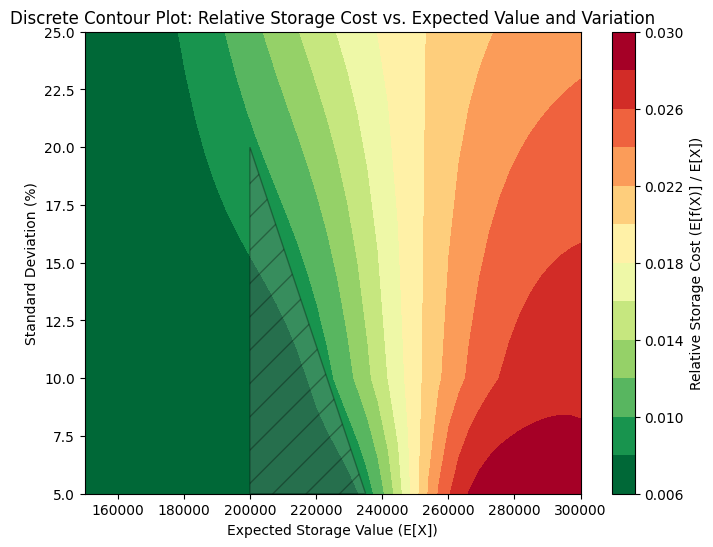

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from matplotlib.patches import Polygon

# 1) SETUP
expected_values = np.linspace(150e3, 300e3, 50)  # Expected storage values
sd_percentages = np.array([0.05, 0.10, 0.25])    # Standard deviations (as % of E[X])
threshold = 250000                              # Threshold value for storage cost

# Create meshgrid for expected values (X-axis) and SD percentages (Y-axis)
E_mesh, sd_pct_mesh = np.meshgrid(expected_values, sd_percentages)

# 2) CALCULATE EXPECTED STORAGE COSTS FOR EACH POINT
storage_costs_mesh = np.zeros_like(E_mesh)
for i in range(E_mesh.shape[0]):
    for j in range(E_mesh.shape[1]):
        e = E_mesh[i, j]
        sd = e * sd_pct_mesh[i, j]  # Standard deviation
        z = (threshold - e) / sd    # z-score
        Phi_z = norm.cdf(z)         # Probability of X < threshold
        one_minus_Phi_z = 1 - Phi_z
        phi_z = norm.pdf(z)

        # Avoid division by zero
        E_X_below = e - sd * (phi_z / Phi_z) if Phi_z > 0 else e
        E_X_above = e + sd * (phi_z / one_minus_Phi_z) if one_minus_Phi_z > 0 else e

        # Expected storage cost
        storage_costs_mesh[i, j] = (
                0.006 * E_X_below * Phi_z
                + (5000 + 0.012 * E_X_above) * one_minus_Phi_z
        )

# 3) RELATIVE STORAGE COST = s(x) / x
relative_cost_mesh = storage_costs_mesh / E_mesh

# 4) DEFINE DISCRETE LEVELS FOR THE CONTOUR
levels = [
    0.006, 0.008, 0.010, 0.012, 0.014,
    0.016, 0.018, 0.020, 0.022, 0.024,
    0.026, 0.028, 0.030
]

# 5) CREATE A DISCRETE COLORMAP (GREEN → YELLOW → RED), WITH EXTENDED BOUNDS
cmap = plt.get_cmap("RdYlGn_r", len(levels) - 1)

# 6) PLOT THE CONTOUR WITH FEWER, DISCRETE COLORS
fig, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(
        E_mesh,
        sd_pct_mesh * 100,
        relative_cost_mesh,
        levels=levels,
        cmap=cmap,
)
triangle_coords = [(200000, 5), (200000, 20), (235000, 5)]
triangle = Polygon(triangle_coords, facecolor="gray", alpha=0.3,
                   edgecolor="black", label="Optimal Area", rasterized=True, hatch="/")
ax.add_patch(triangle)
# 7) COLOR BAR & LABELS
cbar = fig.colorbar(contour, ax=ax)
cbar.set_label("Relative Storage Cost (E[f(X)] / E[X])")
ax.set_xlabel("Expected Storage Value (E[X])")
ax.set_ylabel("Standard Deviation (%)")
ax.set_title("Discrete Contour Plot: Relative Storage Cost vs. Expected Value and Variation")
plt.savefig("../docs/images/color_map_standard_deviation_expected_optimal.png", format="png")

plt.show()
